In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_color_codes("colorblind")

results_raw = pd.read_parquet("results/performance.parquet")
ecmo_size = torch.load("cache/ihmtensors/X_ecmo.pt").shape[0]

results_raw['Fine Tuning Size'] = results_raw['Fine Tuning Size'].apply(lambda x: ecmo_size if x == 0 else x)

pretty_names_map = {
    'combined': 'All ICUs',
    'micu': 'Medical',
    'sicu': 'Surgical',
    'cvicu': 'Cardiovascular',
    'ccu': 'Coronary Care Unit',
    'tsicu': 'Trauma Surgical',
    'nsicu': 'Neurosurgical',
    'msicu': 'Medical Surgical',
    None: 'Unpretrained'
}

results_raw['Pretraining'] = results_raw['Pretraining'].apply(lambda x: pretty_names_map[x])
results_raw = results_raw.rename(columns={'Pretraining': 'ICU Type'})
results_raw.to_csv("results/performance.csv", index=False)


/home/isears/VirtualEnvironments/default/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Performance vs. Fine-Tuning Size

In [2]:
pvft = results_raw[results_raw['Pretraining Size'] == 0].drop(columns=['Pretraining Size'])
pvft = pvft[(pvft['ICU Type'] == 'All ICUs') | (pvft['ICU Type'] == 'Medical')]

[Text(0.5, 1.0, 'Model Performance vs. Fine-Tuning Dataset Size')]

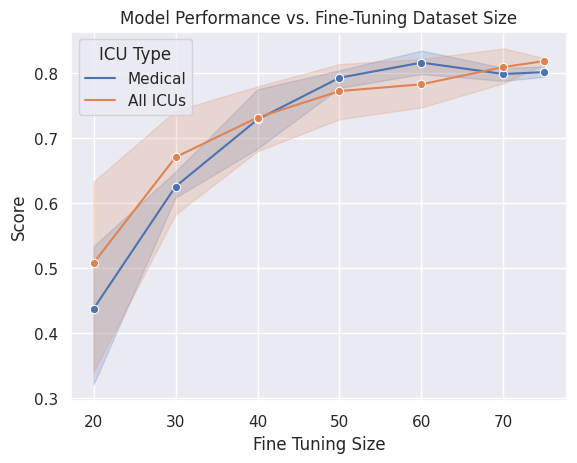

In [3]:
sns.set_theme()

sns.lineplot(
    data=pvft, 
    x="Fine Tuning Size", 
    y="Score", 
    hue="ICU Type", 
    marker='o',
).set(title='Model Performance vs. Fine-Tuning Dataset Size')

# Fixed (n = 1000) vs. Maximum Pretraining Size

In [4]:
fvmp = results_raw[results_raw['Fine Tuning Size'] == ecmo_size].drop(columns=['Fine Tuning Size'])
fixed_pretraining = fvmp[fvmp['Pretraining Size'] == 1000]
max_pretraining = fvmp[fvmp['Pretraining Size'] == 0]

[Text(0.5, 1.0, 'Model Performance by Pretraining Dataset')]

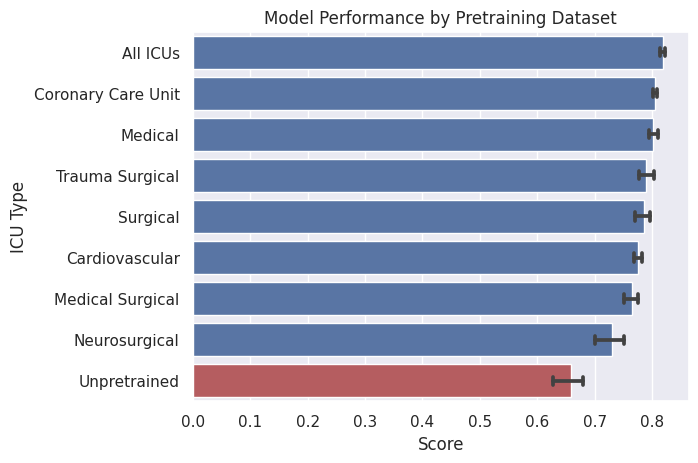

In [5]:
plot_order = max_pretraining.groupby('ICU Type')['Score'].mean().sort_values(ascending=False).index.values
clrs = ['r' if (x == 'Unpretrained') else 'b' for x in plot_order ]

sns.barplot(
    data=max_pretraining, 
    x="Score", 
    y="ICU Type", 
    capsize=0.2,
    order=plot_order,
    orient='h',
    palette=clrs
).set(title='Model Performance by Pretraining Dataset')

[Text(0.5, 1.0, 'Model Performance by Pretraining Dataset\nfixed pretraining dataset size (n=1000)')]

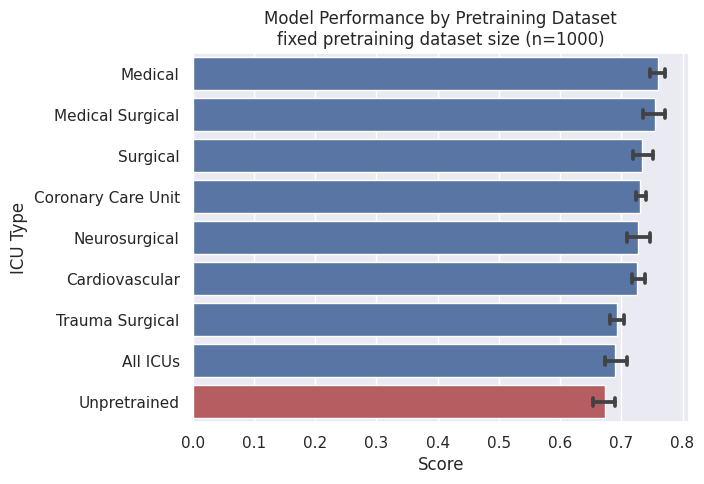

In [6]:
plot_order = fixed_pretraining.groupby('ICU Type')['Score'].mean().sort_values(ascending=False).index.values
clrs = ['r' if (x == 'Unpretrained') else 'b' for x in plot_order ]

sns.barplot(
    data=fixed_pretraining, 
    x="Score", 
    y="ICU Type", 
    capsize=0.2,
    order=plot_order,
    orient='h',
    palette=clrs
).set(title="Model Performance by Pretraining Dataset\nfixed pretraining dataset size (n=1000)")

# Performance by Pretraining Dataset Size

In [7]:
pvpt = results_raw[(results_raw['Pretraining Size'] != 0) & (results_raw['Pretraining Size'] != 1000)]

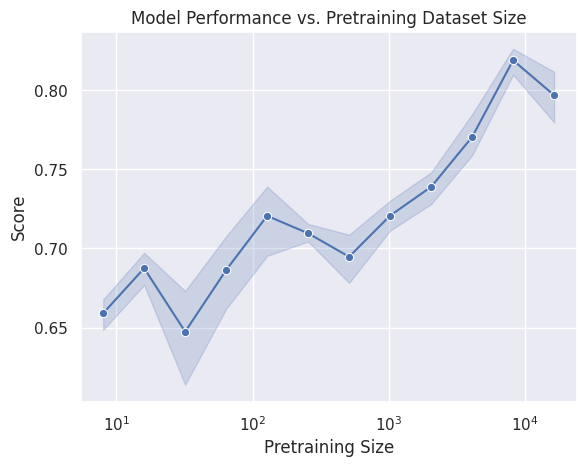

In [8]:
sns.set_theme()

sns.lineplot(
    data=pvpt, 
    x="Pretraining Size", 
    y="Score",
    marker='o',
).set(title='Model Performance vs. Pretraining Dataset Size')
plt.xscale('log')

# Attributions

In [17]:
from tabecmo.dataProcessing import features, feat_category_map

attribs_raw = torch.load('cache/attribs.pt')
attribs_raw = torch.abs(attribs_raw)
attribs_raw = torch.sum(attribs_raw, axis=0)

attribs_df = pd.DataFrame(data={'Feature': features, 'Attribution': attribs_raw})

attribs_df.to_csv("results/attributions.csv", index=False)
attribs_df['Category'] = attribs_df['Feature'].apply(lambda x: feat_category_map[x])

attribs_df

,Feature,Attribution,Category
0,AbsoluteBasophilCount,0.813283,CBC
1,AbsoluteEosinophilCount,0.279888,CBC
2,AbsoluteLymphocyteCount,1.095906,CBC
3,AbsoluteMonocyteCount,0.573100,CBC
4,AbsoluteNeutrophilCount,0.516472,CBC
...,...,...,...
78,temperature,0.228964,Vitals
79,thrombin,0.335929,Coagulation
80,total_protein,0.207179,LFTs
81,totalco2,1.096329,Blood Gases


[Text(0.5, 1.0, 'Summed Absolute Attributions')]

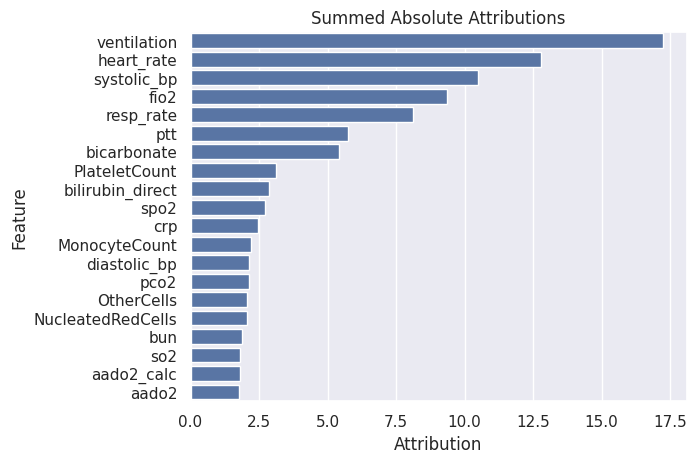

In [15]:

sns.barplot(
    data=attribs_df.nlargest(20, columns=['Attribution']),
    x="Attribution", 
    y="Feature", 
    orient='h',
    palette=['b'] * len(features)
).set(title='Summed Absolute Attributions')

[Text(0.5, 1.0, 'Summed Absolute Attributions')]

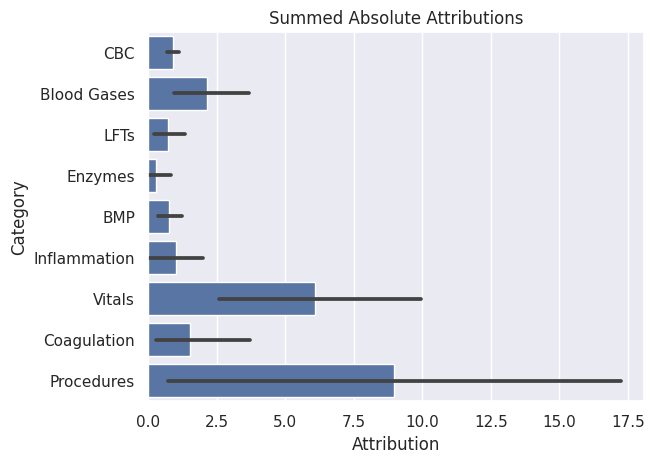

In [16]:
sns.barplot(
    data=attribs_df, 
    x="Attribution", 
    y="Category", 
    orient='h',
    palette=['b'] * len(features)
).set(title='Summed Absolute Attributions')